<a href="https://colab.research.google.com/github/Sinestro38/Generalized-QAOA-to-solve-the-weighted-max-cut-problem/blob/main/Weighted_max_cut_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generalized Weighted Max-cut Solver

A quick note: You can run all of the code blocks below by hovering your mouse over the brackets at the top left of each block and clicking the play button that appears. In order to run a block of code, you have to have already run the subsequent blocks (In other words you have to run the code blocks in order)

## Install packages

In [ ]:
!pip install cirq

# Algorithm implemented on a simple weighted graph

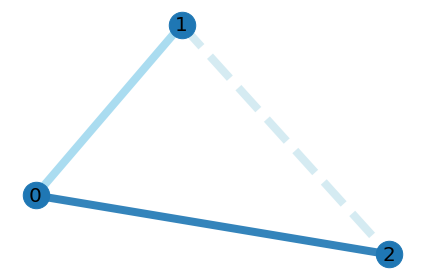

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt

"""INPUTS -- ENTER NUMBER OF NODES AND EDGE SPECIFICATIONS HERE"""
nodes = range(3) # Insert the number of nodes on your graph in the range function
# Each edge in following array is formatted as (start_node, end_node, weight)
E     =[(0,1,0.5), (1,2,0.2), (2,0,0.8)]
# End of input area

### Visualize graph
G = nx.Graph() 
G.add_nodes_from(nodes)
G.add_weighted_edges_from(E)

def draw_networkx(colors=None):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.7]
    emedium = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.7 and d["weight"] > 0.4]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.4]

    pos          = nx.spring_layout(G, seed=7)
    default_axis = plt.axes(frameon=False)

    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=8, alpha=0.9, edge_color="tab:blue")
    nx.draw_networkx_edges(G, pos, edgelist=emedium, width=8, alpha=0.7, edge_color="skyblue")
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=8, alpha=0.5, edge_color="lightblue", style="dashed")
    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=colors)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
draw_networkx()

In [ ]:
import cirq
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize

In [ ]:
# Defines the list of qubits
num = len(nodes)
depth = 4
shots = 1024
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

"""Initializes all qubits into uniform superposition"""
def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

In [ ]:
"""Defines the cost unitary -- encodes time evolution of cost Hamiltonian"""
def cost_unitary(qubits, gamma):
    for i in E:
        start_node = i[0]    #start node of edge
        end_node = i[1]      #end node of edge
        w = i[2]             #weight of edge
        # Encoding time evolution operator (exponentiated cost Hamiltonian) onto circuit
        yield cirq.ZZPowGate(exponent=-1*w*gamma/math.pi).on(qubits[start_node], qubits[end_node])

"""Defines the mixer unitary -- encodes time evolution of Hamiltonian that doesn't commute with cost Hamiltonian"""
def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        # Increasing the probability of measurement for states marked by cost unitary 
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

In [ ]:
"""Executes the circuit"""
def create_circuit(params):
    gamma = [params[0], params[2], params[4], params[6]] # parameters for each cost layer
    alpha = [params[1], params[3], params[5], params[7]] # parameters for each mixer layer

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits)) # Initializing all qubits by applying a Hadamard transform
    
    """For each layer, append a cost layer and a mixer layer to the circuit consecutively with the matching parameters"""
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    
    circuit.append(cirq.measure(*qubits, key='x')) # Measure the circuit

    """Conducts several shots of the circuit to inspect probability distribution and output bitstrings that were measured"""
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=shots)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, shots):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)
    return new_res

Now, we are able to create our cost function, in order to post-process the data measured from the quantum circuit executions. The cost function we made here returns a negative value (dependant on the weight) if the nodes are coloured differently and returns 0 if they are coloured the same. Thus, the objective is to minimize the cost function.

In [ ]:
"""Defines the cost function -- runs one epoch"""
def cost_function(params): 
    res = create_circuit(params)
    total_cost = 0
    """Iterate over each result"""
    for i in range(0, len(res)):
        """Iterate over each edge in each result"""
        for j in E:
            start_node = j[0]
            end_node = j[1]
            w = j[2]
            """Calculate the cost of each edge and add it to the total cost"""
            total_cost = total_cost + -1*(w*res[i][start_node]*(1-res[i][end_node]) + w*res[i][end_node]*(1-res[i][start_node]))
    
    """Calculates the average cost over 1000 repitions of the algorithm"""
    total_cost = float(total_cost)/shots 
    print("Cost: "+str(total_cost))

    return total_cost

In [ ]:
"""Defines a classical optimizer to tune the gamma and alpha parameters to minimize the expected value of the cost function"""
init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
print("Cost minimization: \n--------------------------")
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})

optimal_params = out['x']
f = create_circuit(optimal_params)

Cost minimization: 
--------------------------
Cost: -0.6648437499999996
Cost: -0.8997070312500035
Cost: -0.860351562500004
Cost: -0.664257812500001
Cost: -0.2931640625000011
Cost: -0.7821289062500016
Cost: -0.7942382812500061
Cost: -0.6629882812500009
Cost: -0.8046875000000012
Cost: -0.5465820312499994
Cost: -0.8668945312500036
Cost: -0.8868164062500011
Cost: -0.920019531250002
Cost: -0.8964843750000026
Cost: -0.8916015625000029
Cost: -0.9377929687500003
Cost: -0.9911132812499979
Cost: -0.9345703125000016
Cost: -0.8984374999999986
Cost: -0.9624023437499987
Cost: -0.9702148437499978
Cost: -1.07128906249999
Cost: -1.0695312499999932
Cost: -1.0811523437499904
Cost: -1.1252929687499886
Cost: -1.1957031249999828
Cost: -1.1924804687499844
Cost: -1.1907226562499833
Cost: -1.215039062499983
Cost: -1.2042968749999834
Cost: -1.1898437499999845
Cost: -1.207812499999983
Cost: -1.1500976562499865
Cost: -1.1893554687499848
Cost: -1.199218749999982
Cost: -1.2242187499999817
Cost: -1.2219726562499822

In [ ]:
"""Given a list of results and corresponding frequency, this function outputs the 2 solutions"""
def get_max_and_secondmax(freq, nums, want_second_max):
    first_solution = nums[freq.index(np.amax(freq))]

    mx=max(freq[0],freq[1]) 
    secondmax=min(freq[0],freq[1])
    n =len(freq)
    for i in range(2,n):
        if freq[i]>mx: 
            secondmax=mx
            mx=freq[i] 
        elif freq[i]>secondmax and \
            mx != freq[i]: 
            secondmax=freq[i]
    second_solution = nums[freq.index(secondmax)]
    
    if want_second_max == "Yes":
        return first_solution, second_solution
    else:
        return first_solution

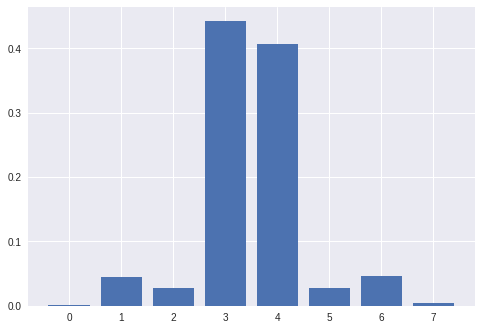

In [ ]:
"""Plots histogram of results from optimized QAOA circuit"""
nums = []
freq = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    number = 0
    # Converting result bit string into integer value
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    # Recording result
    if (number in nums):
        freq[nums.index(number)] += 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq] # Scaling frequencies to sum to one

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.style.use("seaborn")
plt.bar(x, y)
plt.show()

Above you can see a histogram showing the probabilities corresponding to each bitstring. Since this has been run on the optimal parameters, we know that the two states with the highest probability of being measured are the solutions to our weighted max-cut problem! As you can see, in this simple case the states with highest probability of measurement are $|3\rangle = |011\rangle $ and $|4\rangle = |100\rangle $. Notice why we have *two* optimal solutions, both $|2\rangle $ and $|13\rangle $ have the maximum cut. This is because the  actual set a given node belongs to doesn't matter as long as the difference between the node sets stays the same. Thus, $|011\rangle$ and $|100\rangle$ have the same cut! I implore you to check it on your own. 

In [ ]:
top_int_solution, second_int_solution = get_max_and_secondmax(freq, nums, "Yes")
print(f"\n --------------------------------------------------------------------------------------------------------------------\
---------- \n  The two solutions for your weighted max-cut graph is {top_int_solution} \
({np.binary_repr(top_int_solution, width=len(f[100]))}) and {second_int_solution} \
({np.binary_repr(second_int_solution, width=len(f[100]))})!\n -------------------------------------------------------------\
----------------------------------------------------------------- \n")


 ------------------------------------------------------------------------------------------------------------------------------ 
  The two solutions for your weighted max-cut graph is 3 (011) and 4 (100)!
 ------------------------------------------------------------------------------------------------------------------------------ 



In [ ]:
"""Retrieving top solution in binary--value indicates which set the node belongs to"""
nums_bin = []
freq_bin = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    # Recording result
    if (f[i] in nums_bin):
        freq_bin[nums_bin.index(f[i])] += 1
    else:
        nums_bin.append(f[i])
        freq_bin.append(1)
top_bin_solution = get_max_and_secondmax(freq_bin, nums_bin, "No")

Solution graph (3 [0, 1, 1]):


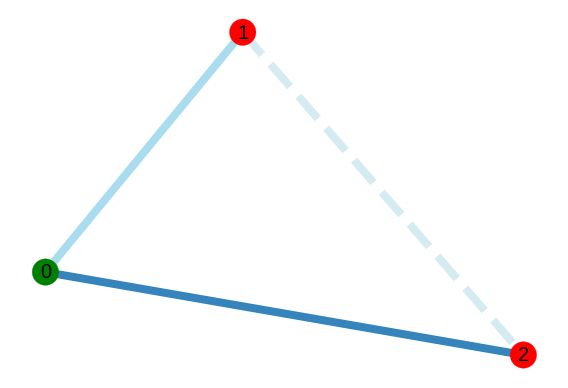

In [ ]:
"""Visualizing graph with Max-Cut colouring"""
colors = [] #setting up a list of colors
for node in top_bin_solution:
    if node == 0:
        colors.append("green")
    else:
        colors.append("red")

print(f"Solution graph ({top_int_solution} {top_bin_solution}):")
draw_networkx(colors)

# Demonstration on a more complex graph

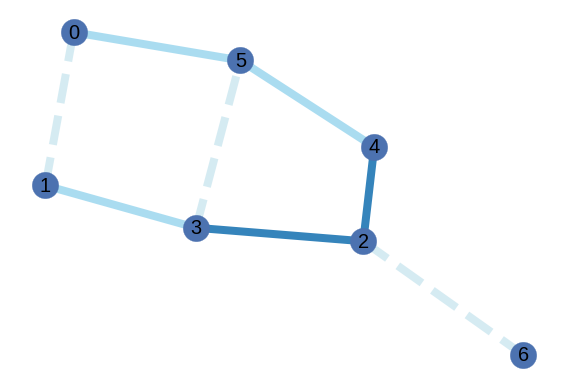

In [ ]:
"""INPUTS -- ENTER NUMBER OF NODES AND EDGE SPECIFICATIONS HERE"""
nodes = range(7) # Insert the number of nodes on your graph in the range function
# Each edge in following array is formatted as (start_node, end_node, weight)
E     =[(0,1,0.2), (0,5,0.5), (1,3,0.7), (2,6,0.3), (2,3,0.8), (2,4,1), (3,5,0.1), (4,5,0.5)]
# End of input area

### Visualize graph
G = nx.Graph() 
G.add_nodes_from(nodes)
G.add_weighted_edges_from(E)

draw_networkx()

In [ ]:
# Defines the list of qubits
num = len(nodes)
depth = 4
shots = 1024
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

"""Defines a classical optimizer to tune the gamma and alpha parameters to minimize the expected value of the cost function"""
init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
print("Cost minimization: \n--------------------------")
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})

optimal_params = out['x']
f = create_circuit(optimal_params)

Cost minimization: 
--------------------------
Cost: -2.292578124999976
Cost: -2.254296874999977
Cost: -2.2498046874999806
Cost: -2.2624999999999793
Cost: -1.654296874999989
Cost: -1.4681640624999952
Cost: -2.020410156249997
Cost: -1.9450195312499854
Cost: -1.970605468749975
Cost: -2.003906249999983
Cost: -2.2238281249999803
Cost: -2.3320312499999836
Cost: -2.3062499999999786
Cost: -2.2375976562499806
Cost: -2.248339843749983
Cost: -2.421386718749974
Cost: -2.4293945312499754
Cost: -2.4562499999999736
Cost: -2.5013671874999672
Cost: -2.498632812499966
Cost: -2.422656249999975
Cost: -2.389550781249976
Cost: -2.557031249999962
Cost: -2.5460937499999603
Cost: -2.536621093749969
Cost: -2.475585937499976
Cost: -2.458203124999971
Cost: -2.473632812499969
Cost: -2.448828124999968
Cost: -2.548339843749966
Cost: -2.437207031249973
Cost: -2.5051757812499678
Cost: -2.4703124999999706
Cost: -2.5488281249999636
Cost: -2.51357421874997
Cost: -2.528320312499968
Cost: -2.549121093749969
Cost: -2.49589

In [ ]:
"""Retrieving top solution in binary--value indicates which set the node belongs to"""
nums_bin = []
freq_bin = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    # Recording result
    if (f[i] in nums_bin):
        freq_bin[nums_bin.index(f[i])] += 1
    else:
        nums_bin.append(f[i])
        freq_bin.append(1)
top_bin_solution = get_max_and_secondmax(freq_bin, nums_bin, "No")

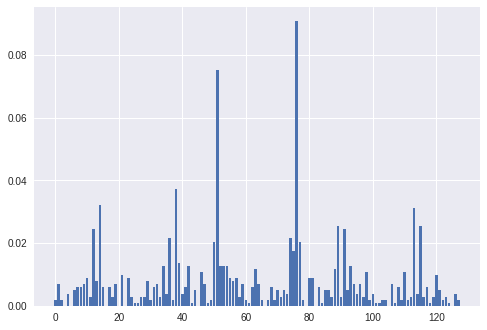


 ------------------------------------------------------------------------------------------------------------------------------ 
  The two solutions for your weighted max-cut graph is 76 (1001100) and 51 (0110011)!
 ------------------------------------------------------------------------------------------------------------------------------ 



In [ ]:
nums = []
freq = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    number = 0
    # Converting result bit string into integer value
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    # Recording result
    if (number in nums):
        freq[nums.index(number)] += 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq] 

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.style.use("seaborn")
plt.bar(x, y)
plt.show()

top_int_solution, second_int_solution = get_max_and_secondmax(freq, nums, "Yes")
print(f"\n --------------------------------------------------------------------------------------------------------------------\
---------- \n  The two solutions for your weighted max-cut graph is {top_int_solution} \
({np.binary_repr(top_int_solution, width=len(f[100]))}) and {second_int_solution} \
({np.binary_repr(second_int_solution, width=len(f[100]))})!\n -------------------------------------------------------------\
----------------------------------------------------------------- \n")

Solution graph colouring (76 [1, 0, 0, 1, 1, 0, 0]):


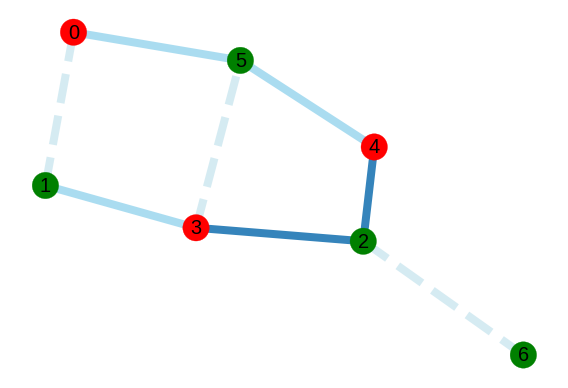

In [ ]:
"""Visualizing graph with Max-Cut colouring"""
colors = [] #setting up a list of colors
for node in top_bin_solution:
    if node == 0:
        colors.append("green")
    else:
        colors.append("red")

print(f"Solution graph colouring ({top_int_solution} {top_bin_solution}):")
draw_networkx(colors=colors)